*   ベースディレクトリと、出力ディレクトリを設定します。

In [1]:
############################################
BaseDir      = 'IntroDDSJpn/Chap02/'
OutputDir    = '2GPyOpt-1103demo/'
FileBaseName = '2GPyOpt-1103demo'

*   Google Colabかどうかを判別し、このJupyter Notebookのあるディレクトリを特定します。

In [2]:
############################################
import sys
import os
############################################
def IsGoogleColab():
  if 'google.colab' in sys.modules:
    return True
  else:
    return False
############################################
if IsGoogleColab():
  #
  from google.colab import drive
  drive.mount('/content/drive')
  #
  IpynbDir = 'drive/My Drive/Colab Notebooks/' + BaseDir
else:
  #
  IpynbDir =  os.getcwd() + '/'
############################################
print( 'ipynb file path = %s' % IpynbDir )

ipynb file path = d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/


*   必要なパッケージを読み込み、ファイルの出力先のディレクトリを用意します。

In [3]:
############################################
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
# %matplotlib notebook
print('matplotlib Ver.', mpl.__version__)
#
############################################
import numpy as np
print('numpy      Ver.', np.__version__)
#
############################################
import pandas as pd
print('pandas     Ver.', pd.__version__)
#
############################################
from sklearn.preprocessing import MinMaxScaler
#
############################################
from mpl_toolkits.mplot3d import Axes3D
#
# ############################################
# # https://docs.pymc.io/
# import pymc as pm
# import time
# print('pymc       Ver.', pm.__version__)
#
# ############################################
# import pickle
#
# ############################################
# # 複数の png を mp4 に
# import cv2
#
############################################
FilePath = IpynbDir + OutputDir
print( 'FilePath = %s' % FilePath )
#
if( True != os.path.isdir(FilePath) ):
    print('  making %s' % FilePath )
    os.mkdir(FilePath)
else:
    print(' %s is exist.' % FilePath )

matplotlib Ver. 3.9.2
numpy      Ver. 1.26.4
pandas     Ver. 2.2.3
FilePath = d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/2GPyOpt-1103demo/
  making d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/2GPyOpt-1103demo/


Rosenbrock関数

デモンストレーション用に、2変数のRosenbrock関数を元に、ベイズ最適化用の計測データを用意する。ただし、2変数の範囲は以下の範囲とする。
* $x_1=220\sim240$
* $x_2=0.5\sim1.5$

以下で定義される Rosenbrock関数は
$$
f(x_1',x_2') = (1.0-x_1')^2 + 100(x_2'-x_1'^2)^2 + c
$$

* $x_1',x_2'=-2.0\sim+2.0$
の範囲で、$(x_1',x_2')=(+1.0, +1.0)$で$c$に最小化することが知られている。

よって以下の変換をしておく。
* $x_1'=0.1\times(x_1-220)$
* $x_2'=4.0\times(x_2-1.0)$

よって$(x_1,x_2')=(+230.0, +1.25)$で$c$に最小化する

In [4]:
############################################
def Rosenbrock( x1, x2 ):
  return np.sqrt( (1-x1)**2 + 100*(x2-x1**2)**2 + 1 )
#
############################################
def rb_func( X_1, X_2 ):
  x_1 = 0.1 * (X_1 - 220)
  x_2 = 4.0 * (X_2 - 1.0)
  return Rosenbrock( x_1, x_2 )

Rosenbrock関数
デモンストレーション用に、2変数のRosenbrock関数を元に、ベイズ最適化用の計測データを用意する。ただし、2変数の範囲は以下の範囲とする。
* $x_1=210\sim240$
* $x_2=0.5\sim2.0$
のグラフを描く

In [5]:
############################################
def Grf2D_rb( measures=None ):
  # 表示範囲
  x_1 = np.linspace(210, 240, 81, endpoint=True )
  x_2 = np.linspace(0.5, 2.0, 81, endpoint=True )
  #
  X_1,X_2 = np.meshgrid(x_1, x_2)
  #
  # Rosenbrock関数
  Z = rb_func(X_1,X_2)
  #
  # 最小点
  min_x_1 = 230
  min_x_2 = 1.25
  min_z   = rb_func(min_x_1,min_x_2)
  #
  # 色目盛
  Z_min = np.amin( Z )
  Z_max = np.amax( Z )
  levs = np.linspace( Z_min, Z_max, num=15 )
  #
  #
  plt.rcParams['font.size'] = 20
  #
  fig = plt.figure( figsize=(6,6) )
  #
  fig.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.12)
  #
  ax1 = fig.add_subplot(1,1,1)
  ax1.set_xlabel( r'$x_{1}$' )
  ax1.set_ylabel( r'$x_{2}$' )
  #
  # 等高線図
  ax1.contour(x_1,x_2,Z,levels=levs,cmap="viridis")
  # plt.colorbar()
  #
  # 最小点
  ax1.axhline(y=min_x_2, linestyle='dashed', color='blue' )
  ax1.axvline(x=min_x_1, linestyle='dashed', color='blue' )
  ax1.text( min_x_1, min_x_2, '(%.1f)' % min_z, fontsize=14, color='blue' )
  #
  # 測定値等の表示
  if measures is not None:
    c_ = 1
    for measure in measures:
      x_1_ = measure[0]
      x_2_ = measure[1]
      z_   = measure[2]
      ax1.text( x_1_, x_2_, '(%d:%.1f)' % (c_,z_), fontsize=14, color='red' )
      ax1.scatter( x_1_, x_2_, color='red' )
      #
      c_ = c_ + 1
  #
  plt.show()
  #
  return fig

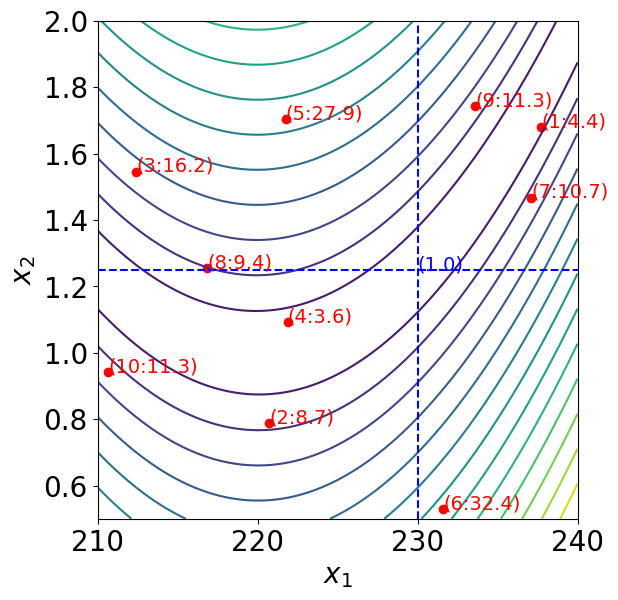

In [6]:
############################################
# デモのため乱数シードを設定
np.random.seed(1346)
#
############################################
# 何点測定するか?
measure_c = 10
#
############################################
# 測定をデモンストレーション
measure = np.zeros( (measure_c,3 ) )
measure[:,0] = 210 + 30  * np.random.rand( measure_c )
measure[:,1] = 0.5 + 1.5 * np.random.rand( measure_c )
measure[:,2] = rb_func(measure[:,0],measure[:,1])
#
############################################
# 測定結果をグラフ化
fig = Grf2D_rb(measure)
#
fig.savefig( FilePath + FileBaseName + 'measures-01.pdf' )
#
############################################
# 測定結果をxlsxで出力
df =pd.DataFrame( measure, columns=['x1','x2', 'y'])
#
df.to_excel( FilePath + FileBaseName + 'measures-01.xlsx' )